**Generative Modelling for Financial Losses**
---


In the last two decades, the increasing number of shocks and financial crises has been a major issue for the financial risk management teams.

Among the wide range of exercises in this field, Stress tests have become a main guideline for the regulator in order to assess the banking system resilience against the realizations of various categories of risk (market, credit, operational, climate, etc). The main challenge is to simulate unfavorable extreme (but plausible) negative returns similar to a historical dataset.

**Task**
----
This is an unsupervised learning problem: Given real data from stock market indexes that will act as a train dataset, the task is to learn a generative model that simulates synthetic stock market indexes.

The difficulty mainly lies in two points :

- find an appropriate transformation to generate extreme values for some given input noise,

- learning a generative model based on a dataset which contains very few extreme data.

**Solution**
---
we are going to generate Tabular Synthetic Dataset with GANs. The new generated data is similar to the given dataset or input feature.

For the given unsupervised learning task, we use the deep learning architecture called GANs (Generative Adversarial Networks) to generate the synthetic data as similar to the input data.

GANs having two part:

- Generator which is used to generate the fake data from the random input noise.
- Descriminator which is used for the classification between the real and the fake data.

Currently GANS is popular applied to generate image data, but few on the tabular data. One of the reason is non-image synthetic data is difficult to evaluate the quality. In this post, we will try to generate one dimensional synthetic data from scratch.



In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from numpy.random import randn

**load the dataset**
----

In [2]:
from google.colab import files
uploaded= files.upload()

Saving train.csv to train.csv


In [3]:
dt= pd.read_csv("train.csv", header=None, names=[0,1,2,3])

In [4]:
dt.head()

,0,1,2,3
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499


In [5]:
print('Type of data',type(dt))
print('length of the data', len(dt))
print('no of columns', dt.columns)

Type of data <class 'pandas.core.frame.DataFrame'>
length of the data 746
no of columns Int64Index([0, 1, 2, 3], dtype='int64')


In [6]:
#for checking the null or empty entries
dt.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

First step, with the help of generate_latent_points function, it will create random noise in the latent space and be reshaped to the dimensions for matching the input of generator model.

In [7]:
# generate points in latent space
def generate_latent_points(latent_dim, n_samples):
	# generate random points (Noise in the latent point)
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network 
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

generate_fake_samples function to produce fake data. The input of the generator will be the created latent points (random noise).
The generator will predict the input random noise and output a numpy array. Because it is the fake data.

In [8]:
# use the generator to generate n fake examples
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs with fake values
	X = generator.predict(x_input)
	# create class labels 
	y = np.zeros((n_samples, 1))
	return X, y

generate_real_sample function is to generate real samples, it will randomly select samples from the real dataset (input).

In [9]:
# generate n real samples with class labels
def generate_real_samples(n):
    X = dt.sample(n)  
  #generate class labels
    y = np.ones((n, 1))
    return X, y

**Generator Model**

Sequential model as generator with Keras module. The input dimension will be the same as the dimension of input samples.

In [85]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=4):
  model = Sequential()
  model.add(Dense(8, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) # 15*15 = 150 + 15 = 165
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.7))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(n_outputs, activation='linear'))
  return model

In [86]:
generator1 = define_generator(10, 4)   #latent_dimension 10 and the number of  output  can be same as  the number of input feature
generator1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_26 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 132       
Total params: 908
Trainable params: 908
Non-trainable params: 0
_________________________________________________________________


**Descriminator Model**

The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake (generated). The discriminator is a normal (and well understood) classification model.

In [97]:
# define the standalone discriminator model
def define_discriminator(n_inputs=4):
  model = Sequential()
  model.add(BatchNormalization())
  model.add(Dense(8, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs)) # we use sigmoid because we need to  classify the real and fake data
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid')) # classification layer
	# compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [98]:
discriminator1 = define_discriminator(4)
#discriminator1.summary()

It is also a sequential model and combine generator with discriminator. NOTE: the discriminator model weight must be not trainable

In [99]:
# combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [100]:
!pip install plot_keras_history

In [101]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
	# plot loss
	plt.subplot(1, 1, 1)
	plt.plot(d_hist, label='d')
	plt.plot(g_hist, label='gen')
	plt.show()
	plt.close()

**Model Training**
---

Train the generator and discriminator. For each epoch, we will combine half batch of real data and half batch of fake data, then calculate the average loss. The combined model will be updated based on **train_on_batch function**. The trained generator will be saved for further use.

In [118]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=128):
  
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)

  d_history = []
  g_history = []
  
  # manually enumerate epochs
  for epoch in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
    d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    
    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    
    # update the generator via the discriminator's error
    g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)

    print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
    d_history.append(d_loss)
    g_history.append(g_loss_fake)

  plot_history(d_history, g_history)
  g_model.save('trained_generated_model_20210205_v3.h5')

In [119]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], color='red')
	pyplot.scatter(x_fake[:, 0], color='blue')
	pyplot.show()

We input latent_dim value is 4 out of 100 / 512 (dimension) to start the training. 

Given a small latent space, the AE produces low quality and the GAN
produces high quality outputs from a perceptual viewpoint. In contrast, the distortion error is smaller for the AE. By increasing the dimensionality of the latent space the distortion decreases for both models, but the perceptual quality only increases for the AE. ref: https://openreview.net/forum?id=Hygy01StvH

>1, d1=0.714, d2=0.880 d=0.797 g=0.640
>2, d1=0.708, d2=0.872 d=0.790 g=0.637
>3, d1=0.727, d2=0.839 d=0.783 g=0.638
>4, d1=0.744, d2=0.872 d=0.808 g=0.634
>5, d1=0.739, d2=0.828 d=0.784 g=0.616
>6, d1=0.739, d2=0.847 d=0.793 g=0.654
>7, d1=0.723, d2=0.890 d=0.807 g=0.589
>8, d1=0.739, d2=0.766 d=0.753 g=0.627
>9, d1=0.736, d2=0.825 d=0.781 g=0.597
>10, d1=0.718, d2=0.814 d=0.766 g=0.623
>11, d1=0.707, d2=0.793 d=0.750 g=0.562
>12, d1=0.779, d2=0.773 d=0.776 g=0.577
>13, d1=0.752, d2=0.778 d=0.765 g=0.538
>14, d1=0.723, d2=0.753 d=0.738 g=0.572
>15, d1=0.727, d2=0.760 d=0.744 g=0.580
>16, d1=0.740, d2=0.774 d=0.757 g=0.559
>17, d1=0.743, d2=0.834 d=0.789 g=0.533
>18, d1=0.750, d2=0.769 d=0.759 g=0.534
>19, d1=0.738, d2=0.757 d=0.748 g=0.537
>20, d1=0.747, d2=0.724 d=0.735 g=0.555
>21, d1=0.731, d2=0.765 d=0.748 g=0.534
>22, d1=0.747, d2=0.786 d=0.766 g=0.495
>23, d1=0.738, d2=0.737 d=0.738 g=0.524
>24, d1=0.789, d2=0.793 d=0.791 g=0.540
>25, d1=0.740, d2=0.753 d=0.746 g=0.527
>26, d1=0

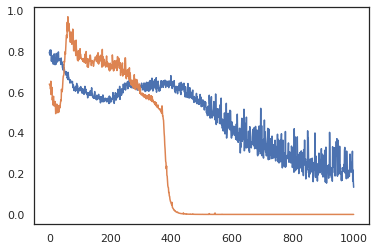

In [120]:
# size of the latent space
latent_dim = 10
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

As in the above graph: The Loss of generator and discriminator changes are plotted as followed: blue-loss of discriminator; orange-loss of generator

**Evaluate the Quality of Generated Fake Data With Model**
---


We have trained the generator successfully in the above steps. From this section, we will produce the fake data with the trained model and test the quality of the fake data. First, we will load the trained generator model.

In [20]:
from keras.models import load_model
model = load_model('/content/trained_generated_model_20210205_v3.h5')

In [21]:
weights = model.get_weights() # Getting params
weights=pd.DataFrame(weights)
weights.to_csv('parameters.csv', index=False, header=None)

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [103]:
latent_points = generate_latent_points(10, 410)  # we use according to our dataset

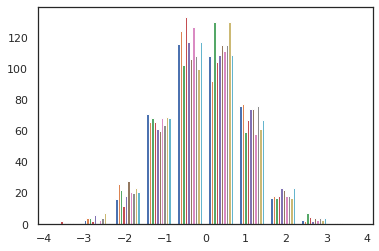

In [104]:
plt.hist(latent_points,bins=10)
plt.show()

In [105]:
Noise=pd.DataFrame(latent_points)
Noise.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.668654,-1.732633,0.018611,-1.147804,-0.573643,1.472097,1.419763,1.115888,-0.660325,0.658060
1,-1.218013,-0.711840,1.506322,0.202139,-1.629295,-1.155098,0.943868,-0.032295,0.161136,-0.976684
2,0.021971,0.425154,-1.193868,1.438663,1.884483,-0.377533,0.883917,-1.497679,0.899256,-0.048231
3,-1.293910,-0.158506,-0.041834,0.031828,0.700948,0.811118,0.183310,1.095103,-0.665111,0.536658
4,-0.071902,-0.140734,0.512127,0.264332,1.293696,-0.420600,-0.414686,1.732371,0.480191,0.379632


In [106]:
#download the csv of fake data
Noise.to_csv('Noise.csv', index=False, header=None)

In [107]:
X = model.predict(Noise)

In [108]:
data_fake = pd.DataFrame(data=X)

In [109]:
data_fake.head()

,0,1,2,3
0,0.007436,0.004815,0.013135,0.004356
1,0.016793,0.009866,0.005707,-0.000584
2,0.013437,0.005237,0.004787,0.008186
3,0.010141,-0.001354,0.012963,0.004561
4,0.007085,-0.000865,0.009988,0.002472


In [110]:
(dt < 0).sum()

0    0
1    0
2    0
3    0
dtype: int64

In [111]:
(data_fake < 0).sum()

0     3
1    63
2     8
3    46
dtype: int64

In [29]:
#download the csv of fake data
data_fake.to_csv('Data.csv', index=False,header=None)

In [112]:
print('FAKE DATA',data_fake.describe())
print('REAL DATA',dt.describe())

FAKE DATA                 0           1           2           3
count  410.000000  410.000000  410.000000  410.000000
mean     0.009685    0.005393    0.008697    0.004004
std      0.004889    0.005574    0.005290    0.004136
min     -0.007545   -0.011607   -0.007270   -0.013263
25%      0.006609    0.001280    0.005232    0.002627
50%      0.009060    0.005098    0.007912    0.004153
75%      0.011847    0.008883    0.011229    0.005338
max      0.028247    0.029144    0.030713    0.024352
REAL DATA                 0           1           2           3
count  746.000000  746.000000  746.000000  746.000000
mean     0.013144    0.012822    0.009366    0.010788
std      0.011914    0.011712    0.009283    0.009338
min      0.000012    0.000057    0.000014    0.000067
25%      0.004761    0.003878    0.003202    0.004226
50%      0.010030    0.009423    0.006641    0.008508
75%      0.017771    0.017810    0.012354    0.014221
max      0.098709    0.088502    0.072016    0.074291


**Evaluate the Quality of Generated Fake Data With Table_evaluator**
---
Table_evaluator is a library to evaluate how similar a synthesized dataset is to a real dataset. It is suitable for evaluating the generated synthetic data. First we will install the table_evaluator module.


In [35]:
!pip install table_evaluator

  Created wheel for table-evaluator: filename=table_evaluator-1.2.2.post1-py3-none-any.whl size=17051 sha256=824319df7128a76afb4744481927aaa429dcae0d706365bf5b0da27fb98fadec
  Stored in directory: /root/.cache/pip/wheels/45/c7/20/47a3f8b044d705f3c088d9577968a805dded4b83096fabd2ac
Successfully built table-evaluator


In [36]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(dt, data_fake)

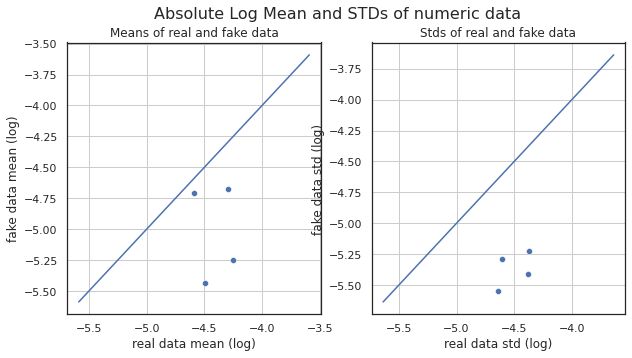

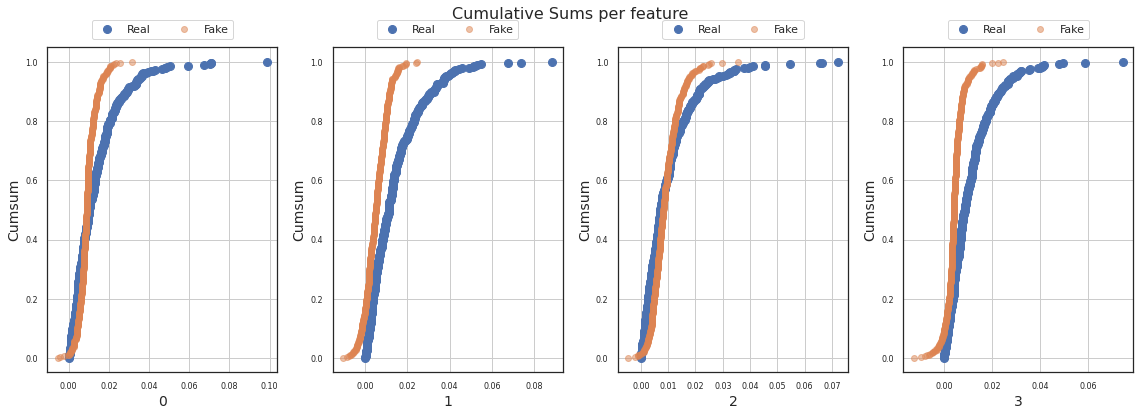

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

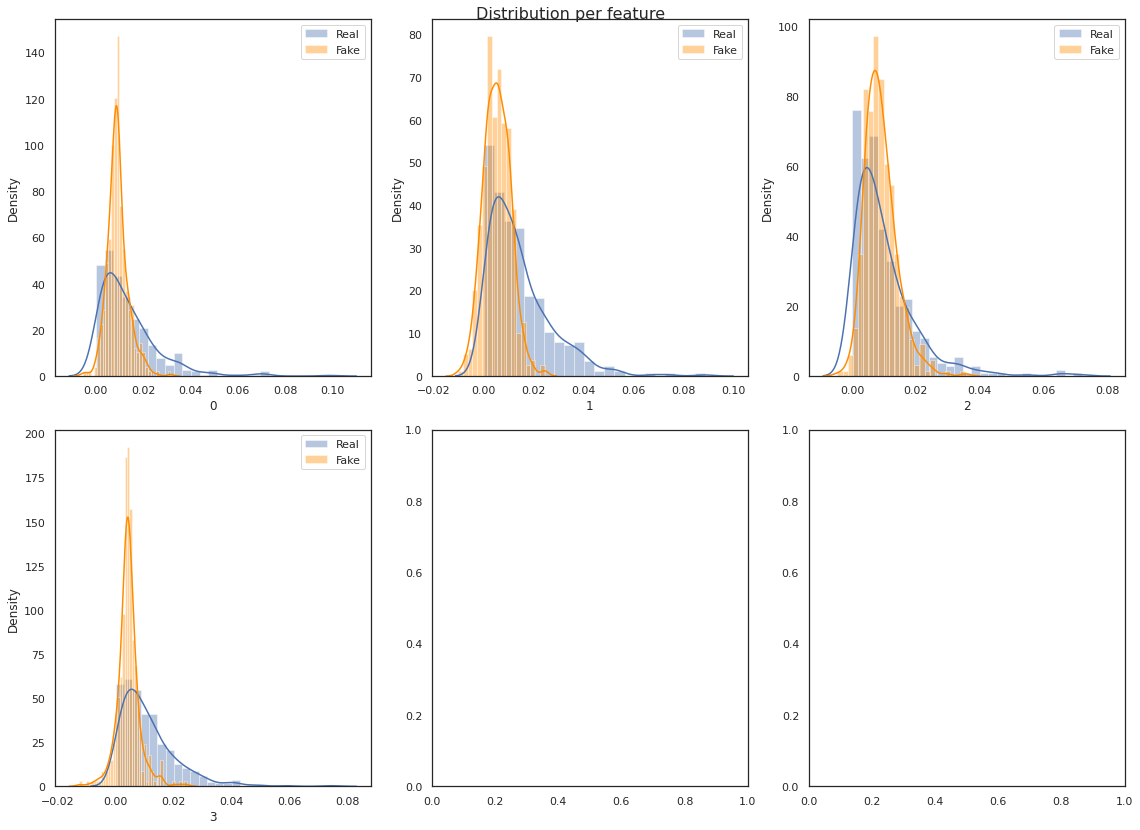

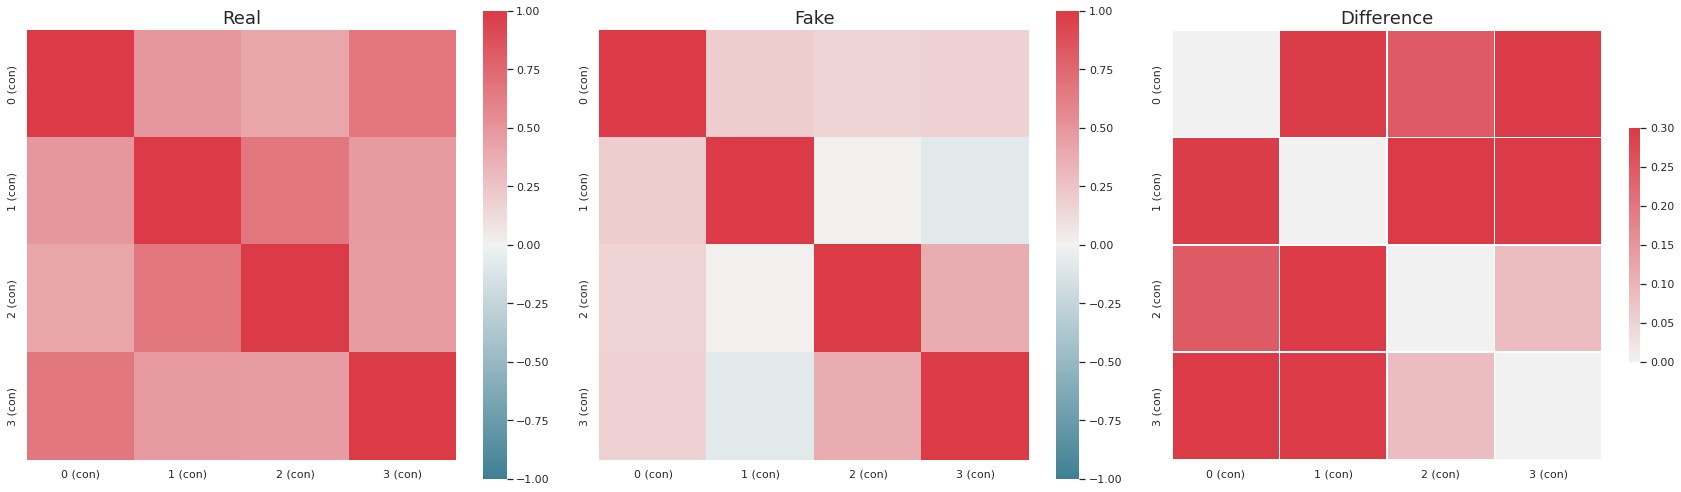

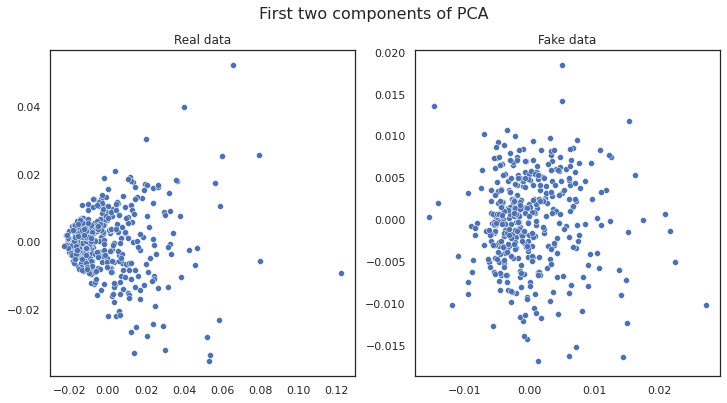

In [113]:
table_evaluator.visual_evaluation()

In [63]:
def marginals(X_real, X_fake):
  n,d = X_real.shape
  U = []
  for i in range(n):
    U.append(1/(n+2) * ((X_real <= X_fake[i]).sum(axis=0) + 1))
  U = np.array(U)
  
  W = n * np.ones((1,d))
  for i in range(n):
    W = W - 1/n * (2*i+1)*(np.log10(U[i]) + np.log(1-U[-i-1]))
  return W.sum()/d

In [69]:
def dependence(X_real, X_fake):
  n,d = X_real.shape
  Z_real = []
  Z_fake = []
  for i in range(n):
    Z_real.append(1/(n-1) * ((X_real < X_real[i]).sum(axis=1)==d).sum())
    Z_fake.append(1/(n-1) * ((X_fake < X_fake[i]).sum(axis=1)==d).sum())
  
  return 1/n * np.abs(np.array(Z_real) - np.array(Z_fake)).sum()

In [114]:
data_fake

,0,1,2,3
0,0.007436,0.004815,0.013135,0.004356
1,0.016793,0.009866,0.005707,-0.000584
2,0.013437,0.005237,0.004787,0.008186
3,0.010141,-0.001354,0.012963,0.004561
4,0.007085,-0.000865,0.009988,0.002472
...,...,...,...,...
405,0.011432,0.006987,0.009736,0.002484
406,0.006230,0.003027,0.002924,0.007806
407,0.010869,-0.000978,0.015457,0.004353
408,0.005529,-0.000842,0.008778,0.002943


In [115]:
dt.iloc[:410,:].to_numpy()

array([[1.2495353e-02, 1.1125671e-02, 3.2520460e-03, 6.6249110e-03],
       [1.1438864e-02, 2.6905690e-03, 1.2064370e-03, 6.9467200e-03],
       [6.3166400e-04, 7.2773960e-03, 4.0486520e-03, 7.4500000e-05],
       ...,
       [6.3772060e-03, 6.9311770e-03, 1.9939862e-02, 4.2842040e-03],
       [7.1021330e-03, 9.1017660e-03, 2.2724390e-03, 8.7497430e-03],
       [4.0756978e-02, 1.4501014e-02, 1.6574811e-02, 1.7284381e-02]])

In [116]:
marginals(dt.iloc[:410,:].to_numpy(),data_fake.to_numpy())

914.095797422571

In [117]:
dependence(dt.iloc[:410,:].to_numpy(),data_fake.to_numpy())

0.20277893732482558

**Summary**
---
From the model table_evaluator evaluation, we could draw the conclusion that some of the features match closely with those of real data.

References
---

https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/


https://medium.com/analytics-vidhya/a-step-by-step-guide-to-generate-tabular-synthetic-dataset-with-gans-d55fc373c8db